In [1]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import argparse
import sys

import torch

import rlcard

from rlcard.agents import DQNAgent, RandomAgent
from rlcard.utils import (
    get_device,
    set_seed,
    tournament,
    reorganize,
    Logger,
    plot_curve,
)

import numpy as np
from tqdm import tqdm

In [3]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce GTX 1080 Ti


In [4]:
def block():
    sys.stdout = open(os.devnull, 'w')
    
def unblock():
    sys.stdout = sys.__stdout__
    
# block()
# print("HI")
# unblock()
    

In [5]:
# Initialize the Uno environment
env = rlcard.make('uno')

In [6]:
# The paths for saving the logs and learning curves
log_dir = './experiments/uno_dqn_result/'

In [7]:
agent = DQNAgent(
                 num_actions=env.num_actions,
                 state_shape=env.state_shape[0],
                 mlp_layers=[128,128], #changed to 128
                 replay_memory_size=5000,
                 update_target_estimator_every=100,
                 epsilon_decay_steps=10000,
                 learning_rate=0.001,
                 batch_size=32,
                 device=device,
                 save_path=log_dir,
                 )

In [8]:
# Set the number of players
num_players = 4

# Set the players in the environment
env.set_agents([agent] + [RandomAgent(env.num_actions) for _ in range(num_players - 1)])

# Reset the environment
state = env.reset()

## Training the Agent
To train the agent, you will need to create a training loop. During each iteration of the loop, the agent makes a decision, the environment is updated, and the agent learns from the result.

In [9]:
# Reward function for static moves on action cards, playing and drawing cards
def adjust_rewards(trajectories, payoffs):
    adjusted_trajectories = []
    for traj in trajectories:
        adjusted_traj = []
        for state, action, reward, next_state, done in traj:
            if action == 60:  # Draw a card
                reward -= 1  # Penalty for drawing a card

            elif action >= 0 and action <= 9:  # Red number cards
                reward += 1
            elif action >= 10 and action <= 12:  # Red action cards
                reward += 3
            elif action == 13:  # Red wild card
                reward += 6
            elif action == 14:  # Red wild and draw 4 card
                reward += 10

            elif action >= 15 and action <= 24:  # Green number cards
                reward += 1
            elif action >= 25 and action <= 27:  # Green action cards
                reward += 3
            elif action == 28:  # Green wild card
                reward += 6
            elif action == 29:  # Green wild and draw 4 card
                reward += 10

            elif action >= 30 and action <= 39:  # Blue number cards
                reward += 1
            elif action >= 40 and action <= 42:  # Blue action cards
                reward += 3
            elif action == 43:  # Blue wild card
                reward += 6
            elif action == 44:  # Blue wild and draw 4 card
                reward += 10

            elif action >= 45 and action <= 54:  # Yellow number cards
                reward += 1
            elif action >= 55 and action <= 57:  # Yellow action cards
                reward += 3
            elif action == 58:  # Yellow wild card
                reward += 6
            elif action == 59:  # Yellow wild and draw 4 card
                reward += 10
                
            adjusted_traj.append((state, action, reward, next_state, done))
        adjusted_trajectories.append(adjusted_traj)
    return adjusted_trajectories

In [10]:
def adjust_rewards(trajectories, payoffs):
    adjusted_trajectories = []
    for traj in trajectories:
        adjusted_traj = []
        for state, action, reward, next_state, done in traj:
            # Actual game state details
            raw_obs = state['raw_obs']
            
            # Retrieve the number of cards in player's hand
            num_cards_player = len(raw_obs['hand'])
            
            # Provide the number of cards for each player with the current player being index 0
            num_cards_opponent = raw_obs['num_cards'][1] if raw_obs['current_player'] == 0 else raw_obs['num_cards'][0]

            if action == 60:  # Draw a card
                reward -= max(1, 3 - num_cards_player / 7)

            # Adjust rewards for action cards based on the opponent's hand size
            action_card_reward_multiplier = max(1, (7 - num_cards_opponent) / 7)

            if action in range(10, 15) or action in range(25, 30) or action in range(40, 45) or action in range(55, 60):
                reward += 2 * action_card_reward_multiplier

            if action in range(0, 10) or action in range(15, 25) or action in range(30, 40) or action in range(45, 55):
                reward += 1 + (3 - num_cards_player / 7)

            adjusted_traj.append((state, action, reward, next_state, done))
        adjusted_trajectories.append(adjusted_traj)
    return adjusted_trajectories


# Building out the simulation

Previously, the code would run an entire/complete simulation. However, this restricts the ability to learn from moves within the simulation.

In [ ]:
episode_num = 25000  # Number of episodes 

evaluate_every = 1000 # Evaluate the agent every X episodes
evaluate_num = 100  # Number of games played in evaluation

with Logger(log_dir) as logger:
    for episode in tqdm(range(episode_num)):  # Number of episodes

        trajectories, payoffs = env.run(is_training=True)

        # Assuming 'payoffs' are the game outcomes for each player
        for i, payoff in enumerate(payoffs):
            if payoff > 0:  # Assuming a positive payoff means winning
                payoffs[i] = 100
            else:
                payoffs[i] = -25

        trajectories = reorganize(trajectories, payoffs)

        # After reorganizing the trajectories, adjust the rewards
        trajectories = adjust_rewards(trajectories, payoffs)
        # print(trajectories[0])

        for ts in trajectories[0]:
            block()
            agent.feed(ts)
            unblock()
        
        if episode % evaluate_every == 0:
                logger.log_performance(
                    episode,
                    tournament(
                        env,
                        evaluate_num,
                    )[0]
                )
                

    # Get the paths
    csv_path, fig_path = logger.csv_path, logger.fig_path

 77%|███████▋  | 19151/25000 [35:21<11:07,  8.76it/s]  

## Evaluating the Agent
After training, evaluate your agent's performance. You can use RLCard's tournament function to play the game multiple times and see how well your agent performs:

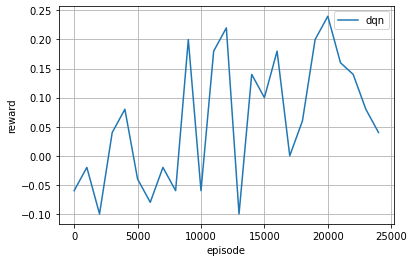

In [35]:
# Plot the learning curve
plot_curve(csv_path, fig_path, "dqn")

# Save model
save_path = os.path.join(log_dir, 'model.pth')
torch.save(agent, save_path)
print('Model saved in', save_path)